In [1]:
# Goal: define a set of molecules that will be different from the train / test split of the GuacaMol dataset

In [96]:
import os, logging, argparse, torch

import torch.distributed as dist

from socket import gethostname
from torch.distributed.elastic.multiprocessing.errors import record

from jointformer.configs.dataset import DatasetConfig
from jointformer.configs.tokenizer import TokenizerConfig
from jointformer.configs.model import ModelConfig
from jointformer.configs.trainer import TrainerConfig
from jointformer.configs.logger import LoggerConfig

from jointformer.utils.datasets.auto import AutoDataset
from jointformer.utils.tokenizers.auto import AutoTokenizer
from jointformer.models.auto import AutoModel
from jointformer.utils.loggers.auto import AutoLogger

from jointformer.trainers.trainer import Trainer

from jointformer.utils.runtime import set_seed, create_output_dir, set_to_dev_mode, log_args, dump_configs
from jointformer.utils.ddp import init_ddp, end_ddp
from jointformer.utils.data_collators import DataCollator
from tqdm import tqdm

from jointformer.utils.metrics.perplexity import Perplexity

from jointformer.utils.data import read_strings_from_file, save_strings_to_file

import numpy as np

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def save_floats_to_txt(filename, float_list):
    with open(filename, 'w') as file:
        for number in float_list:
            file.write(f"{number}\n")

def load_floats_from_txt(filename):
    with open(filename, 'r') as file:
        float_list = [float(line.strip()) for line in file]
    return float_list

In [98]:
# Configs

TARGET_LABEL = 'qed'
REPOSITORY_DIR = '/home/adamizdebski/projects/jointformer'
DATA_DIR = '/home/adamizdebski/files/data'
OUTPUT_DIR = f'/home/adamizdebski/files/jointformer/results/jointformer/finetune/{TARGET_LABEL}'

PATH_TO_DATASET_CONFIG   = f'/home/adamizdebski/projects/jointformer/configs/datasets/guacamol/{TARGET_LABEL}'
PATH_TO_TOKENIZER_CONFIG = '/home/adamizdebski/projects/jointformer/configs/tokenizers/smiles'
PATH_TO_MODEL_CONFIG = '/home/adamizdebski/projects/jointformer/configs/models/jointformer'
PATH_TO_TRAINER_CONFIG = '/home/adamizdebski/projects/jointformer/configs/trainers/joint'

PATH_TO_PRETRAINED_MODEL = '/home/adamizdebski/files/results/jointformer/ckpt.pt'

In [99]:
os.chdir(REPOSITORY_DIR)

In [100]:
dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
tokenizer_config = TokenizerConfig.from_config_file(PATH_TO_TOKENIZER_CONFIG)
model_config = ModelConfig.from_config_file(PATH_TO_MODEL_CONFIG)
trainer_config = TrainerConfig.from_config_file(PATH_TO_TRAINER_CONFIG)

In [101]:
# Test Datsaset // load all guacamol data

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
tokenizer_config = TokenizerConfig.from_config_file(PATH_TO_TOKENIZER_CONFIG)

train_dataset = AutoDataset.from_config(dataset_config, data_dir=DATA_DIR, split='train')
val_dataset = AutoDataset.from_config(dataset_config, data_dir=DATA_DIR, split='val')
test_dataset = AutoDataset.from_config(dataset_config, data_dir=DATA_DIR, split='test')

tokenizer = AutoTokenizer.from_config(tokenizer_config)
perplexity = Perplexity(reduction='none')

In [102]:
model = AutoModel.from_config(model_config)

In [85]:
trainer_config.tasks = {'generation': 1.0}

In [86]:
trainer = Trainer(
    seed=1337,
    config=trainer_config,
    model=model,
    tokenizer=tokenizer,
    test_dataset=test_dataset
) 
trainer._init_data_loaders()
trainer.resume_from_file(PATH_TO_PRETRAINED_MODEL)

In [9]:
test_perplexities = []
trainer.model.eval()

with torch.no_grad():
    for idx, inputs in enumerate(tqdm(trainer.test_loader)):
        inputs.to(trainer.device)
        output = trainer.model(**inputs)       
        test_perplexities.extend(perplexity(output['logits_generation'], inputs['attention_mask']).tolist())

100%|██████████| 467/467 [02:44<00:00,  2.83it/s]


In [10]:
test_perplexities

[1.3656286001205444,
 1.3011503219604492,
 1.3030260801315308,
 1.5233919620513916,
 1.227721095085144,
 1.3928442001342773,
 1.311170220375061,
 1.2984119653701782,
 1.4302371740341187,
 1.346763014793396,
 1.3493330478668213,
 1.2995115518569946,
 1.5374972820281982,
 1.3157153129577637,
 1.284447193145752,
 1.1859967708587646,
 1.4359405040740967,
 1.582695484161377,
 1.4587385654449463,
 1.3350993394851685,
 1.3382817506790161,
 1.312196969985962,
 1.4068877696990967,
 1.3103687763214111,
 1.20890212059021,
 1.2170078754425049,
 1.289820671081543,
 1.1825248003005981,
 1.3034225702285767,
 1.3424904346466064,
 1.3371657133102417,
 1.2895839214324951,
 1.212703824043274,
 1.3109469413757324,
 1.443695306777954,
 1.2663854360580444,
 1.272749423980713,
 1.2331575155258179,
 1.2212985754013062,
 1.28682541847229,
 1.3524287939071655,
 1.2676808834075928,
 1.327812910079956,
 1.3524839878082275,
 1.3106964826583862,
 1.3871138095855713,
 1.38434898853302,
 1.7605204582214355,
 1.441922

In [11]:
len(test_perplexities)

238706

In [12]:
# save test perplexities

with open('test_perplexities.txt', 'w') as file:
    for number in test_perplexities:
        file.write(f"{number}\n")

In [15]:
np.array(test_perplexities).max()

2.286909341812134

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
import requests
import pandas as pd

url = "https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("data.csv", "wb") as file:
        file.write(response.content)
        file.seek(0)
        df = pd.read_csv("data.csv")
else:
    print("Failed to download the file.")

data = df[df['SPLIT'] == 'test'].SMILES.tolist()

In [16]:
from jointformer.utils.datasets.smiles.base import SmilesDataset

smiles_dataset = SmilesDataset(data=data)
collator = DataCollator(tokenizer=tokenizer, tasks={'generation': 1})
loader = torch.utils.data.DataLoader(
                smiles_dataset,
                batch_size=512,
                num_workers=4,
                pin_memory=True,
                shuffle=False,
                collate_fn=collator
            )


In [17]:
non_test_perplexities = []
trainer.model.eval()

with torch.no_grad():
    for idx, inputs in enumerate(tqdm(loader)):
        inputs.to(trainer.device)
        output = trainer.model(**inputs)       
        non_test_perplexities.extend(perplexity(output['logits_generation'], inputs['attention_mask']).tolist())

  0%|          | 0/344 [00:00<?, ?it/s]

100%|██████████| 344/344 [02:01<00:00,  2.83it/s]


In [18]:
non_test_perplexities

[1.643728494644165,
 2.738812208175659,
 2.185342788696289,
 3.2293896675109863,
 2.18890380859375,
 2.608180522918701,
 2.8490147590637207,
 2.3266637325286865,
 2.9982266426086426,
 3.4845235347747803,
 2.8208250999450684,
 1.933174967765808,
 1.8546154499053955,
 2.2938997745513916,
 1.9105936288833618,
 2.6012179851531982,
 2.1716690063476562,
 3.3710176944732666,
 2.309462785720825,
 2.54822039604187,
 3.1157925128936768,
 2.0982143878936768,
 3.147728681564331,
 2.521622657775879,
 1.5385770797729492,
 3.247580051422119,
 2.857135057449341,
 1.8479573726654053,
 3.1100375652313232,
 2.3585684299468994,
 2.5953192710876465,
 2.3946049213409424,
 1.930336594581604,
 2.4471755027770996,
 1.79954993724823,
 2.5859267711639404,
 1.7758557796478271,
 2.78629732131958,
 3.1815648078918457,
 2.040472984313965,
 1.753906488418579,
 2.6136879920959473,
 2.0778064727783203,
 2.726914882659912,
 1.5126864910125732,
 2.1646223068237305,
 1.9492871761322021,
 2.790364980697632,
 2.215572118759

In [19]:
# save test perplexities

with open('non_test_perplexities.txt', 'w') as file:
    for number in non_test_perplexities:
        file.write(f"{number}\n")

In [39]:
with open('non_test_perplexities.txt', 'r') as file:
    non_test_perplexities = [float(line.strip()) for line in file]

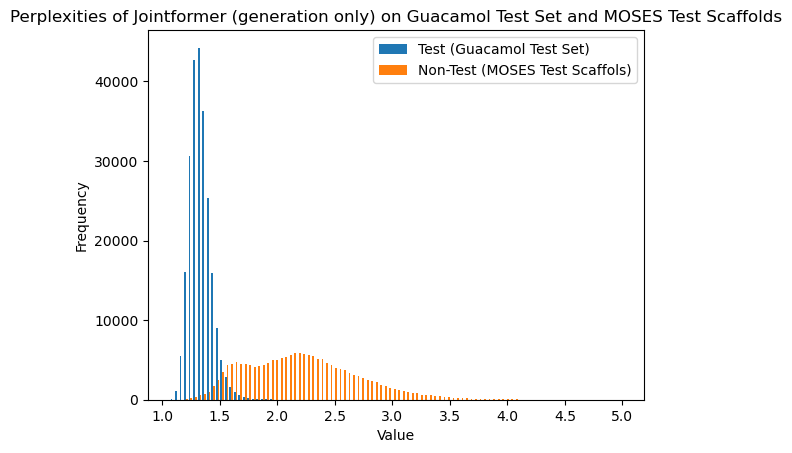

In [20]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist([test_perplexities, non_test_perplexities], label=['Test (Guacamol Test Set)', 'Non-Test (MOSES Test Scaffols)'], bins=100)
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.title('Perplexities of Jointformer (generation only) on Guacamol Test Set and MOSES Test Scaffolds')
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Show that the ones passing filters have lower perplexity. 

In [85]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist([perplexities, perplexities_nontest], label=['Test (Guacamol Test Set)', 'Non-Test (MOSES Test Scaffols)'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Perplexities of Jointformer on Guacamol Test Set and MOSES Test Scaffolds')
plt.legend()

# Display the plot
plt.show()

512

In [ ]:
# Ideas:

1. 

Check holdout
check https://github.com/BenevolentAI/guacamol/blob/master/guacamol/utils/chemistry.py#L302 taninmoto

In [17]:
test_perplexities = load_floats_from_txt('test_perplexities.txt')
non_test_perplexities = load_floats_from_txt('non_test_perplexities.txt')

In [18]:
test_perplexities = np.array(test_perplexities)
non_test_perplexities = np.array(non_test_perplexities)

In [19]:
max(test_perplexities)

2.286909341812134

In [23]:
np.max(non_test_perplexities)

4.995883464813232

In [25]:
np.where(non_test_perplexities > np.max(test_perplexities), )

(array([     1,      3,      5, ..., 176068, 176070, 176072]),)

In [51]:
cutoff = np.quantile(non_test_perplexities, 0.999)
high_perplexity_smiles = [smiles for smiles, condition in zip(data, non_test_perplexities) if condition > cutoff]

In [54]:
high_perplexity_smiles

['O=c1c2ccccc2n2nnnc2n1-c1ccccc1',
 'Nc1cccc(F)c1-c1nc(-c2ccncc2)n[nH]1',
 'Cc1sc2ncn3cnnc3c2c1-c1ccc(F)cc1',
 'Nc1cccnc1Sc1nc2cccnc2s1',
 'O=C1c2ccccc2-c2nc3ncnn3c(-c3ccccc3)c21',
 'O=c1ccccn1Cc1ccccc1Br',
 'Nc1ccc(Cl)cc1-c1nc2ccccc2[nH]c1=O',
 'Nc1nonc1-c1nc2ccccc2n1Cc1ccccc1',
 'O=c1c2ccccc2nc(-c2ccoc2)n1-c1ccccc1',
 'Nc1ncnc2c1ncn2-c1ccc(Cl)cc1Cl',
 'O=c1c2ccccc2nnn1CSc1nnc(-c2ccco2)o1',
 'N#Cc1ccccc1CSc1ncnc2c1cnn2-c1ccccc1',
 'Cc1cc2nccc(-c3cnc4sc5ccccc5n4c3=O)n2n1',
 'O=c1c2cnn(-c3ccccc3)c2ncn1Cc1cccnc1',
 'Nc1cccc2ccc(-c3cnc4ccccc4c3)nc12',
 'N#Cc1cccn1-c1nccc(-c2cccs2)n1',
 'O=C(c1ccccc1)c1c[nH]nc1-c1ccccc1O',
 'Fc1ccccc1C=Cc1nn2c(-c3ccncc3)nnc2s1',
 'O=c1c2ccccc2nnn1COc1cccc2cccnc12',
 'N#Cc1ccccc1Cn1nnc(-c2ccncc2)n1',
 'O=C(c1cccnc1)n1nc(-c2cccnc2)nc1NCc1ccco1',
 'O=c1c2ccccc2c(-c2cccs2)nn1-c1ccccn1',
 'Nc1ncnc2c1ncn2C(c1ccccc1)c1ccccc1',
 'Cn1ncc2c1ncn1nc(-c3cc4ccccc4cc3O)nc21',
 'O=c1ccc(-c2cccc3ccccc23)nn1Cc1cccnc1',
 'O=c1c2ccccc2nnn1Cc1coc(-c2cccs2)n1',
 'O=c1[nH]c2cccc

In [53]:
len(high_perplexity_smiles)

177

In [94]:
cutoff = 4. #  np.max(test_perplexities)
high_perplexity_smiles = [smiles for smiles, condition in zip(data, non_test_perplexities) if condition > cutoff]
low_perplexity_smiles = [smiles for smiles, condition in zip(data, non_test_perplexities) if condition < 2.]

In [95]:
low_perplexity_smiles

['CC1=CC=C(C=C1)C1=CC(=NN1C1=CC=C(C=C1)S(N)(=O)=O)C(F)(F)F']

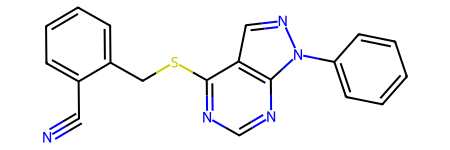

In [75]:
from rdkit import Chem
from rdkit.Chem import Draw



mol = Chem.MolFromSmiles(high_perplexity_smiles[11], sanitize=False)
mol    

In [ ]:
# calculate the SA score for molecules

In [63]:
Draw.MolsToGridImage(mol_list)


RuntimeError: Pre-condition Violation
	getExplicitValence() called without call to calcExplicitValence()
	Violation occurred on line 298 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_explicitValence > -1
	RDKIT: 2023.09.2
	BOOST: 1_82


In [87]:
data = [
    'CC1=CC=C(C=C1)C1=CC(=NN1C1=CC=C(C=C1)S(N)(=O)=O)C(F)(F)F',
    'Clc4cccc(N3CCN(CCCCOc2ccc1c(NC(=O)CC1)c2)CC3)c4Cl',
    'OC1(CN(C1)C(=O)C1=C(NC2=C(F)C=C(I)C=C2)C(F)=C(F)C=C1)C1CCCCN1',
    'COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc2nccc(n2)c3cn(C)c4ccccc34',
    'Cc1c(C)c2OC(C)(COc3ccc(CC4SC(=O)NC4=O)cc3)CCc2c(C)c1O',
    'COc1ccccc1OCC(O)CN2CCN(CC(=O)Nc3c(C)cccc3C)CC2',
    'CN(C)S(=O)(=O)c1ccc2Sc3ccccc3C(=CCCN4CCN(C)CC4)c2c1',
    'CC(C)(C)NCC(O)c1ccc(O)c(CO)c1',
    'CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4',
    'COc1ccc2[C@H]3CC[C@@]4(C)[C@@H](CC[C@@]4(O)C#C)[C@@H]3CCc2c1'
]

In [88]:
from jointformer.utils.datasets.smiles.base import SmilesDataset

smiles_dataset = SmilesDataset(data=data)
collator = DataCollator(tokenizer=tokenizer, tasks={'generation': 1})
loader = torch.utils.data.DataLoader(
                smiles_dataset,
                batch_size=512,
                num_workers=4,
                pin_memory=True,
                shuffle=False,
                collate_fn=collator
            )


In [89]:
target_perplexities = []
trainer.model.eval()

with torch.no_grad():
    for idx, inputs in enumerate(tqdm(loader)):
        inputs.to(trainer.device)
        output = trainer.model(**inputs)       
        target_perplexities.extend(perplexity(output['logits_generation'], inputs['attention_mask']).tolist())

100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


In [90]:
target_perplexities

[1.4084376096725464,
 2.115499258041382,
 1.3685569763183594,
 2.6715588569641113,
 1.9654628038406372,
 2.1801352500915527,
 1.9512168169021606,
 1.8426893949508667,
 2.280790090560913,
 2.5905559062957764]

In [ ]:
def calculate_pairwise_similarities(smiles_list1: List[str], smiles_list2: List[str]) -> np.ndarray:
    """
    Computes the pairwise ECFP4 tanimoto similarity of the two smiles containers.

    Returns:
        Pairwise similarity matrix as np.ndarray
    """
    if len(smiles_list1) > 10000 or len(smiles_list2) > 10000:
        logger.warning(f'Calculating similarity between large sets of '
                       f'SMILES strings ({len(smiles_list1)} x {len(smiles_list2)})')

    mols1 = get_mols(smiles_list1)
    fps1 = get_fingerprints(mols1)

    mols2 = get_mols(smiles_list2)
    fps2 = get_fingerprints(mols2)

    similarities = []

    for fp1 in fps1:
        sims = DataStructs.BulkTanimotoSimilarity(fp1, fps2)

        similarities.append(sims)

    return np.array(similarities)

In [123]:
from guacamol.utils.chemistry import calculate_pairwise_similarities, get_mols, get_fingerprints

In [105]:
test_data = test_dataset.data
non_test_data = data
test_perplexities = load_floats_from_txt('test_perplexities.txt')
non_test_perplexities = load_floats_from_txt('non_test_perplexities.txt')

In [150]:

high_perplexity_smiles = [smiles for smiles, condition in zip(non_test_data, non_test_perplexities) if condition > 2.]
low_perplexity_smiles = [smiles for smiles, condition in zip(non_test_data, non_test_perplexities) if condition <= 2.]

In [118]:
import random

random.sample(high_perplexity_smiles, 100)

['CC(C)C(N)C(=O)NCC1CCCCC1',
 'COc1ccc2oc3cc(C)[n+]([O-])c(-c4ccc(C)cc4)c3c2c1',
 'CCCCCCCCCC(=O)c1n[nH]c2c1C(=O)N(c1ccc([N+](=O)[O-])cc1)C2=O',
 'COc1ccc(-c2csc(N)c2C#N)cc1OC',
 'CCCCCCn1c(=O)c2c3nc(cc4nc(cc5[nH]c(cc6[nH]c2c(c6C)c1=O)c(CC)c5C)C(C(C)OCCCC)=C4C)C(C)C3CCC(=O)OC',
 'Cc1ccc(NC(=O)C2CSCN2C(=O)c2cnn(C)c2)c(C)c1',
 'OC1CCN(Cc2nc(Cc3ccccc3Cl)no2)CC1',
 'O=C(CCCCCN1CCN(c2ncccc2-c2ccncc2)CC1)NCc1ccc(F)nc1',
 'CCS(=O)(=O)N1CCC(c2nnc(CN3CCCCCC3)n2C)CC1',
 'COCCOc1cc2ncc(C(N)=O)c(Nc3ccc(C)cc3F)c2cc1N1CCOCC1',
 'CC(C(=O)Nc1ccc(N2CCOCC2)cc1)N1C(=O)NC(C)(C)C1=O',
 'CN1CCN(C)C1=O',
 'COc1ccccc1NC(=O)Cn1c(=O)n(-c2ccccc2Cl)c(=O)c2sc3ccccc3c21',
 'COCCn1c(SCc2cccc(F)c2)nc2cc(C(=O)OC)ccc2c1=O',
 'CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)NC(COC1OC(CO)C(O)C(O)C1O)C(O)C(O)c1cnn(CCCCCCCc2ccccc2)c1',
 'O=C1c2ccccc2C(=O)N1CN(C(=O)COc1ccccc1)c1ccc(F)cc1',
 'CCCCOCC1CN(CCCC)S(=O)(=O)c2c(F)cccc2O1',
 'CN(C)C(=O)CCC(NC(=O)CNC(=O)OCc1ccccc1)C(=O)CF',
 'CCC=CCn1c(=O)sc2c(=O)[nH]c(N)nc21',
 'COc1nc(OC)nc(-c2cccc(

In [116]:
len(high_perplexity_smiles)

229

In [117]:
len(low_perplexity_smiles)

474

In [119]:
similiarity = calculate_pairwise_similarities(random.sample(low_perplexity_smiles, 100), random.sample(high_perplexity_smiles, 100))

In [121]:
similiarity.shape

(100, 100)

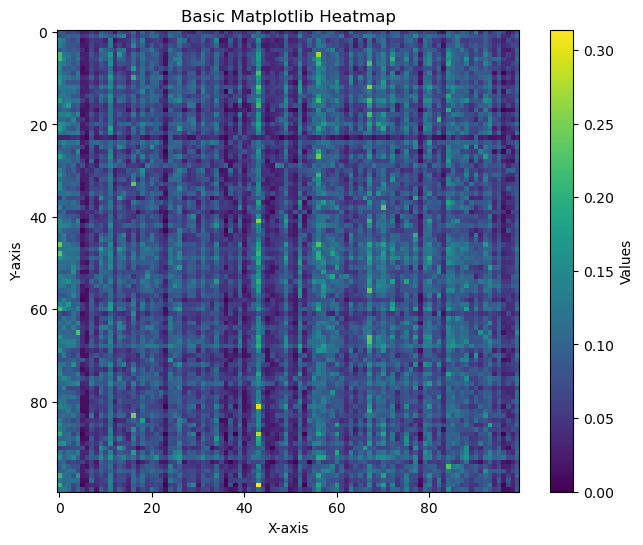

In [122]:
import matplotlib.pyplot as plt
import numpy as np


# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similiarity, cmap='viridis')  # You can choose different colormaps
plt.colorbar(label='Values')  # Add a colorbar to show the value range
plt.title('Basic Matplotlib Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [136]:
from rdkit import RDLogger, DataStructs

mols1 = get_mols([low_perplexity_smiles[0], low_perplexity_smiles[1]])
fps1 = get_fingerprints(mols1)

mols2 = get_mols([low_perplexity_smiles[2], low_perplexity_smiles[3]])
fps2 = get_fingerprints(mols2)

similarities = []

for fp1 in fps1:
    sims = DataStructs.BulkTanimotoSimilarity(fp1, fps2)
    print(sims)

[0.11475409836065574, 0.12727272727272726]
[0.0821917808219178, 0.08955223880597014]


In [138]:
from rdkit import RDLogger, DataStructs

mols1 = get_mols([low_perplexity_smiles[0], low_perplexity_smiles[1]])
fps1 = get_fingerprints(mols1)

mols2 = get_mols([high_perplexity_smiles[2], high_perplexity_smiles[3]])
fps2 = get_fingerprints(mols2)

similarities = []

for fp1 in fps1:
    sims = DataStructs.BulkTanimotoSimilarity(fp1, fps2)
    print(sims)


[0.07462686567164178, 0.11428571428571428]
[0.0641025641025641, 0.08536585365853659]


In [ ]:
# correlate with FCD
# SA score 
# plaussibliity filters for molecules
# do MOSES have additional molecules that would not be in Guacamol?

In [140]:
import networkx as nx
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors

from jointformer.utils.properties.smiles import sascorer

sa = -sascorer.calculateScore(mol)

RuntimeError: Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2023.09.2
	BOOST: 1_82


In [151]:
sa_score_low_perplexity = [sascorer.calculateScore(Chem.MolFromSmiles(smiles)) for smiles in low_perplexity_smiles]

In [152]:
sa_score_high_perplexity = [sascorer.calculateScore(Chem.MolFromSmiles(smiles)) for smiles in high_perplexity_smiles]

In [153]:
np.array(sa_score_low_perplexity).mean()

2.5911153173072763

In [154]:
np.array(sa_score_high_perplexity).mean()

2.369812302090087

In [ ]:
# try simple bitscores